In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from Network_bayesian import Place_net, Grid_net, Coupled_Net
import brainpy as bp
import brainpy.math as bm
from matplotlib.animation import FuncAnimation
import time
from scipy.stats import ttest_ind, norm

# Circular distance function
def circ_dis(phi_1, phi_2):
    dis = phi_1 - phi_2
    dis = np.where(dis > np.pi, dis - 2 * np.pi, dis)
    dis = np.where(dis < -np.pi, dis + 2 * np.pi, dis)
    return dis

In [ ]:
# default parameters
# grid spacing
lambda_1 = 3
lambda_2 = 4
lambda_3 = 5
Lambda = np.array([lambda_1, lambda_2, lambda_3])
L = lambda_1 * lambda_2 * lambda_3
# cell number
num_p = int(200)
rho_p = num_p / L
rho_g = rho_p
num_g = int(rho_g * 2 * np.pi)
M = len(Lambda)
# feature space
x = np.linspace(0, L, num_p, endpoint=False)
theta = np.linspace(0, 2 * np.pi, num_g, endpoint=False)
# connection range
a_p = 0.3
a_g = a_p / Lambda * 2 * np.pi
# connection strength
J_p = 20
J_g = J_p
J_pg = J_p / 25


# divisive normalization
k_p = 20.
k_g = Lambda / 2 / np.pi * k_p
# time constants
tau_p = 1
tau_g = 2 * np.pi * tau_p / Lambda
# input_strength
alpha_p = 0.05
alpha_g = 0.05

noise_ratio = 0.007

P_CANN = Place_net(z_min=0, z_max=L, num=num_p, a_p=a_p, k=k_p, tau=tau_p, J0=J_p)
# Grid cells
G_CANNs = bm.NodeList()
for i in range(M):
    G_CANNs.append(Grid_net(z_min=0, z_max=L, num=num_g, num_hpc=num_p, L=Lambda[i], a_g=a_g[i], k_mec=k_g[i], tau=tau_g[i], J0=J_g, W0=J_pg))

Coupled_model = Coupled_Net(HPC_model=P_CANN, MEC_model_list=G_CANNs, num_module=M)

def Net_decoding(z_truth, phi_truth, Ip, Ig, alpha_p=0.05, alpha_g=0.05, Coupled_model=Coupled_model):
    Coupled_model.reset_state()
    def initial_net(Ip, Ig): 
        Coupled_model.initial(alpha_p=1, alpha_g=1, Ip=Ip, Ig=Ig)

    def run_net(i, Ip, Ig): 
        Coupled_model.step_run(i, alpha_p=1, alpha_g=1, Ip=Ip, Ig=Ig)
        phi_decode = Coupled_model.phase
        z_decode = Coupled_model.HPC_model.center
        rp = Coupled_model.HPC_model.r
        up = Coupled_model.HPC_model.u
        rg = bm.zeros([M, num_g])
        ug = bm.zeros([M, num_g])
        for mi in range(M):
            rg[mi, :] = Coupled_model.MEC_model_list[mi].r
            ug[mi, :] = Coupled_model.MEC_model_list[mi].u
        return z_decode, phi_decode, rp, up, rg, ug

    T_init = 500
    z0 = z_truth
    phi_0 = phi_truth
    fg = np.zeros((M, num_g))
    for i in range(M):
        dis_theta = circ_dis(theta, phi_0[i])
        fg[i, :] = np.exp(-dis_theta ** 2 / (4 * a_g[i] ** 2))
    dis_x = x - z0
    fp = np.exp(-dis_x ** 2 / (4 * a_p ** 2))
    I_place = 1 * np.repeat(fp[np.newaxis, :], T_init, axis=0)
    I_grid = 1 * np.repeat(fg[np.newaxis, :, :], T_init, axis=0)
    I_place[int(T_init / 3):, :] = 0
    I_grid[int(T_init / 3):, :, :] = 0

    bm.for_loop(initial_net, (I_place, I_grid), progress_bar=False)
    T = 5000
    indices = np.arange(T)
    I_place = alpha_p * np.repeat(Ip[np.newaxis, :], T, axis=0)
    I_grid = alpha_g * np.repeat(Ig[np.newaxis, :, :], T, axis=0)
    z_record, phi_record, rp, up, rg, ug = bm.for_loop(run_net, (indices, I_place, I_grid), progress_bar=False)

    return z_record, phi_record, up, rp, ug, rg


In [ ]:
Ap = 1.0084058
Rp = 0.0128615275
Ag = 0.9814125
Rg = 0.013212965

def Grid_tuning_generation(phi_candidate, a_g, num_g):
    # phi_candidate shape: [M, n_candidate]
    n_candidate = phi_candidate.shape[-1]
    theta = np.linspace(0, 2 * np.pi, num_g, endpoint=False)  # Assuming theta is linspace
    
    # Broadcasting phi_candidate to shape [M, 1, n_candidate]
    phi_candidate_expanded = phi_candidate[:, np.newaxis, :]
    
    # Calculate dis_theta using broadcasting
    dis_theta = circ_dis(theta[:, np.newaxis], phi_candidate_expanded)
    
    # Calculate fg_prime using broadcasting
    a_g_expanded = a_g[:, np.newaxis, np.newaxis]
    fg_prime = np.exp(-dis_theta ** 2 / (4 * a_g_expanded ** 2))
    
    return fg_prime



def loglikelihood_Ig(Ig, fg, sigma_g):
    n_phi = fg.shape[-1]
    # Use expand_dims to expand the matrix to shape (n, m, 1)
    Ig_expand = np.expand_dims(Ig, axis=-1)
    # Use tile to repeat the matrix along the last axis K times
    Ig_expand = np.tile(Ig_expand, (1, 1, n_phi))
    log_prob = -0.5 * (Ig_expand - fg)**2 / sigma_g[:,None,None]**2 # shape [M, n_g, n_phi]
    log_prob = np.sum(log_prob, axis=1) 
    return log_prob # shape [M, n_phi]

def mapping_func(x):
    lambda_gs = Lambda
    phi = x[:,None] % Lambda *np.pi*2/Lambda
    return phi # [n_pos, M]

def prior_function(phi, z_candidates, sigma_phi):
    '''
    P(phi | x), phi shape [M], phi_x is a scalar
    '''
    phi_x = mapping_func(z_candidates) # shape [n_pos, M]
    kappa_phi = 1 / (sigma_phi)**2
    log_prob = kappa_phi*np.cos(phi-phi_x) # shape [n_pos, M]
    log_prob_z = np.sum(log_prob, axis=1)
    return log_prob_z # shape [M]

def Simplified_PSC_MAP_decoder(activation_gs, n_pos=4000, n_phi=100, M=3, 
                               alpha_p_infer=0.05, alpha_g_infer=0.05, Ap=Ap, Rp=Rp, Ag=Ag):  
    '''
    MAP: Maximum A Posteriori
    activation_gs shape [M, n_g]
    '''
    sigma_g = np.sqrt(np.sqrt(np.pi) * Ag ** 3 * rho_g * tau_g / (a_g * alpha_g_infer))
    sigma_phi = np.sqrt(8 * np.pi * Ag * tau_g / (Lambda * J_pg * rho_p * Rp))
    sigma_g_infer = sigma_g * noise_ratio
    sigma_phi_infer = sigma_phi * noise_ratio
    
    L_env = 60
    ## parameter space
    z_candidates = np.linspace(0, L_env, n_pos)
    
    phi_candidates = np.linspace(0, 2*np.pi, n_phi, endpoint=False)
    phi_candidates_modules = np.tile(phi_candidates[:, np.newaxis], (1, M))
    phi_candidates_modules = phi_candidates_modules.T
    fg_modules = Grid_tuning_generation(phi_candidates_modules,a_g,num_g) # shape [M, n_g, n_phi]

    log_likelihood_fr = loglikelihood_Ig(activation_gs, fg_modules, sigma_g=sigma_g_infer) # shape [M, n_phi]
    phi_decode_index = np.argmax(log_likelihood_fr, axis=1)

    phi_decode = phi_candidates[phi_decode_index]
    # Second step: decode z
    prior = prior_function(phi_decode, z_candidates, sigma_phi=sigma_phi_infer)
    # plt.plot(prior)
    z_est_index = np.argmax(prior)
    z_decode = z_candidates[z_est_index]
    return z_decode, phi_decode

In [4]:
sigma_g = np.sqrt(np.sqrt(np.pi)*Ag**3*rho_g*tau_g/(a_g*alpha_g)) * 0.01
sigma_phi = np.sqrt(8*np.pi*Ag*tau_g/(Lambda*J_pg*rho_p*Rp)) * 0.01
sigma_p = np.sqrt(np.sqrt(np.pi)*Ap**3*rho_p*tau_p/(a_p*alpha_p)) * 0.01
print(sigma_g, sigma_p, sigma_phi)

[0.19295613 0.19295613 0.19295613] 0.2009713795376621 [0.22407002 0.16805252 0.13444201]


In [5]:
neural_noise_sigma = 0.2
z_truth = 30
phi_truth = np.mod(z_truth / Lambda, 1) * 2 * np.pi 
sigma_phi_noise = np.array([31.7,23.8,19])*neural_noise_sigma/20
print(sigma_phi_noise)
z_truth = 30
phi_truth = np.mod(z_truth / Lambda, 1) * 2 * np.pi 
z_e = z_truth
psi = phi_truth + sigma_phi_noise * np.random.randn(M)

Ig = np.zeros((M, num_g))
for j in range(M):
    dis_theta = circ_dis(theta, psi[j])
    Ig[j, :] = np.exp(-dis_theta ** 2 / (4 * a_g[j] ** 2)) + neural_noise_sigma * np.random.randn(num_g)
dis_x = x - z_e
Ip = np.exp(-dis_x ** 2 / (4 * a_p ** 2)) + neural_noise_sigma * np.random.randn(num_p) 
z_decode, phi_decode = Simplified_PSC_MAP_decoder(activation_gs=Ig, n_pos=4000, n_phi=100, M=3)
print('z_decode:', z_decode)

[0.317 0.238 0.19 ]
z_decode: 30.007501875468865


In [ ]:
c = 0.15  # Constant for off-diagonal positions
# Generate a matrix filled with the constant c
Sigma_G = np.full((num_g, num_g), c)
Sigma_P = np.full((num_p, num_p), c)
np.fill_diagonal(Sigma_G, 1)  # Set diagonal elements to 1
np.fill_diagonal(Sigma_P, 1)  # Set diagonal elements to 1
Lg = np.linalg.cholesky(Sigma_G)  # Cholesky decomposition of Sigma_G
Lp = np.linalg.cholesky(Sigma_P)  # Cholesky decomposition of Sigma_P

In [ ]:
# Main program
neural_noise_sigma = 0.4
trial_num = 100
z_truth = 30
phi_truth = np.mod(z_truth / Lambda, 1) * 2 * np.pi 
sigma_phi = np.array([31.7,23.8,19])*neural_noise_sigma/20

z_decode_MAP = np.zeros(trial_num)
z_decode_net = np.zeros(trial_num)

start_time = time.time()

for i in range(trial_num):
    z_truth = 30
    phi_truth = np.mod(z_truth / Lambda, 1) * 2 * np.pi 
    z_e = z_truth
    psi = phi_truth + sigma_phi * np.random.randn(M)
    Ig = np.zeros((M, num_g))
    for j in range(M):
        dis_theta = circ_dis(theta, psi[j])
        noise_g = neural_noise_sigma * np.random.randn(num_g)
        noise_corr_g = Lg @ noise_g
        Ig[j, :] = np.exp(-dis_theta ** 2 / (4 * a_g[j] ** 2)) + noise_corr_g
        # Ig[j, :] = np.exp(-dis_theta ** 2 / (4 * a_g[j] ** 2)) + neural_noise_sigma * np.random.randn(num_g)
    dis_x = x - z_e
    Ip = 0*(np.exp(-dis_x ** 2 / (4 * a_p ** 2)) + neural_noise_sigma * np.random.randn(num_p) )
    z_decode_n, _, up, rp, ug, rg = Net_decoding(z_truth, phi_truth, Ip, Ig)

    max_up = np.max(up, axis=1)
    max_rp = np.max(rp, axis=1)
    Ap = np.max(max_up[-1])
    Rp = np.max(max_rp[-1])
    Ag = np.zeros(M,)
    Rg = np.zeros(M,)
    for mi in range(M):
        max_ug = np.max(ug[:, mi, :], axis=1)
        max_rg = np.max(rg[:, mi, :], axis=1)
        Ag[mi] = np.max(max_ug[-1])
        Rg[mi] = np.max(max_rg[-1])

    z_decode_m, _ = Simplified_PSC_MAP_decoder(activation_gs=Ig, Ap=Ap, Rp=Rp, Ag=Ag)
    print(z_decode_m)

    z_decode_MAP[i] = z_decode_m
    z_decode_net[i] = z_decode_n[-1][0]
    # if i % 5 == 0:
    #     print(f"Progress: {i/trial_num*100:.2f}%")

end_time = time.time()
print(f"Total runtime: {end_time - start_time:.2f} seconds")

5.761440360090022
29.677419354838708
30.172543135783947
29.99249812453113
9.662415603900975
45.35633908477119
30.037509377344335
29.767441860465116
29.842460615153787
5.521380345086271
14.703675918979744
30.022505626406602
29.902475618904724
5.971492873218304
30.127531882970743
54.23855963990998
5.4463615903976
30.007501875468865
29.662415603900975
54.17854463615904
29.947486871717928
29.947486871717928
29.932483120780194
50.48762190547637
30.022505626406602
29.737434358589645
54.68867216804201
30.127531882970743
45.25131282820705
29.947486871717928
30.037509377344335
30.217554388597147
5.896474118529632
29.932483120780194
29.977494373593398
50.112528132033006
29.677419354838708
30.502625656414104
54.34358589647412
45.28132033008252
30.022505626406602
29.70742685671418
30.007501875468865
54.133533383345835
54.808702175543885
45.116279069767444
30.397599399849963
29.91747936984246
50.15753938484621
50.337584396099025
54.49362340585146
9.767441860465116
29.842460615153787
9.6924231057764

In [ ]:
# Save data as npz file
np.savez('data/MAP_vs_Net_distribution.npz', z_decode_net=z_decode_net, z_decode_MAP=z_decode_MAP)

# Fig. 4c

Net decoding error: 0.207234782394596
MAP decoding error: 14.304481150652


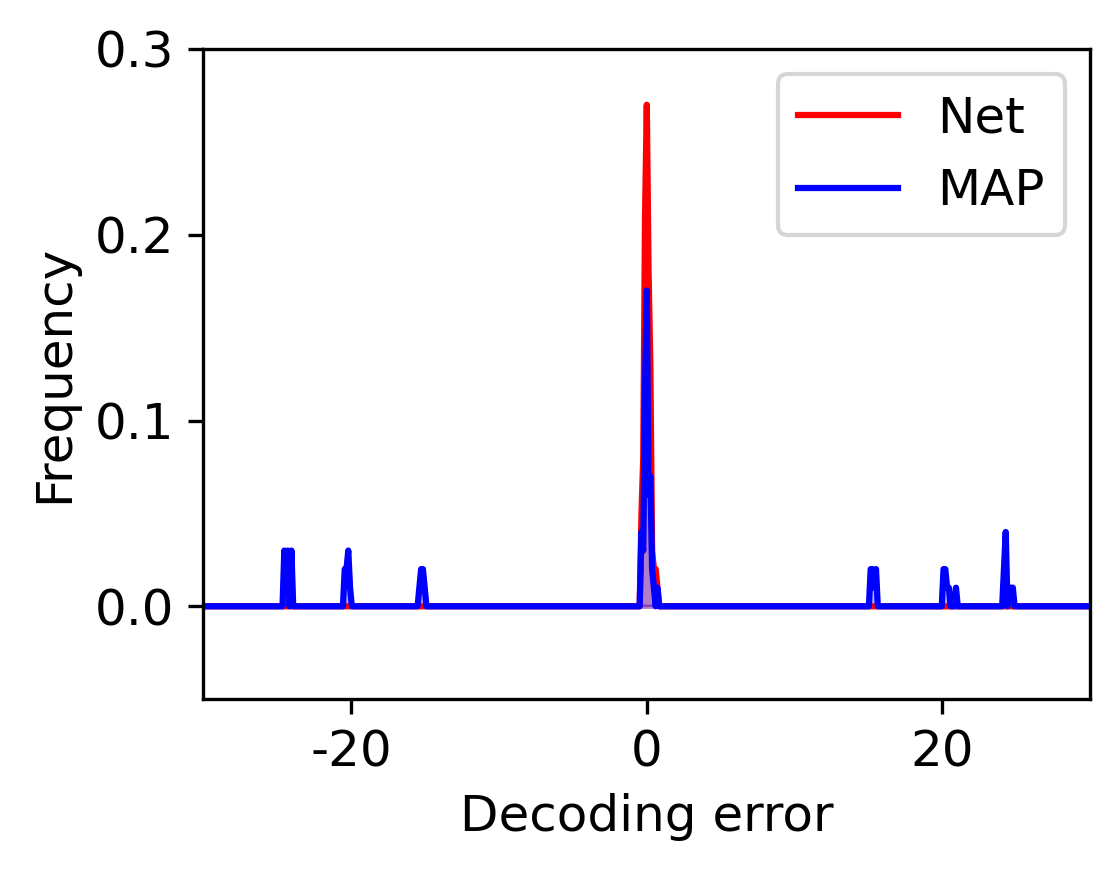

In [ ]:
# data = np.load('data/MAP_vs_Net_distribution.npz')
# z_decode_net = data['z_decode_net']
# z_decode_MAP = data['z_decode_MAP']

z_truth = 30
z_decode_all = np.concatenate([z_decode_net, z_decode_MAP])
min_z = np.min(z_decode_all)
max_z = np.max(z_decode_all)

# font settings
plt.rcParams.update({'font.size': 12, 'font.family': 'DejaVu Sans'})
error_Net = z_decode_net-z_truth
error_MAP = z_decode_MAP-z_truth
print('Net decoding error:', np.std(error_Net))
print('MAP decoding error:', np.std(error_MAP))

# Compute the histogram for the PSC and LSC errors
counts_lsc, bin_edges_lsc = np.histogram(error_Net, bins=np.linspace(-30,30,500))
counts_psc, bin_edges_psc = np.histogram(error_MAP, bins=np.linspace(-30,30,500))


# Calculate the bin centers
bin_centers_psc = (bin_edges_psc[:-1] + bin_edges_psc[1:]) / 2
bin_centers_lsc = (bin_edges_lsc[:-1] + bin_edges_lsc[1:]) / 2

# Remove zero points
# nonzero_indices_lsc = counts_lsc > 0
# bin_centers_lsc = bin_centers_lsc[nonzero_indices_lsc]
# counts_lsc = counts_lsc[nonzero_indices_lsc]

# Plot the histogram with non-zero points only
plt.figure(figsize=(4, 3), dpi=300)
plt.plot(bin_centers_lsc, counts_lsc/np.sum(counts_lsc), label='Net', color='red')
plt.plot(bin_centers_psc, counts_psc/np.sum(counts_psc), label='MAP', color='blue')


plt.fill_between(bin_centers_lsc, counts_lsc/np.sum(counts_lsc), color='red', alpha=0.3)
plt.fill_between(bin_centers_psc, counts_psc/np.sum(counts_psc), color='blue', alpha=0.3)


plt.xlabel('Decoding error')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.ylim(-0.05,0.3)
plt.xlim(-30,30)
plt.xticks([-20, 0, 20], ['-20', '0', '20'])

# plt.savefig('figures_cth/MAP_vs_NET.pdf')
plt.show()

# Fig. 4b

In [ ]:
from matplotlib.ticker import ScalarFormatter

np.random.seed(1)

# Main program
neural_noise_sigma = 0.4
trial_num = 100
z_truth = 30
phi_truth = np.mod(z_truth / Lambda, 1) * 2 * np.pi 
sigma_phi = np.array([31.7,23.8,19])*neural_noise_sigma/20

z_decode_MAP = np.zeros(trial_num)
z_decode_net = np.zeros(trial_num)

start_time = time.time()  # Record start time

i = 0
z_truth = 30
phi_truth = np.mod(z_truth / Lambda, 1) * 2 * np.pi 
z_e = z_truth
psi = phi_truth + sigma_phi * np.random.randn(M)
psi = np.mod(psi, 2 * np.pi)
Ig = np.zeros((M, num_g))
for j in range(M):
  dis_theta = circ_dis(theta, psi[j])
  noise_g = neural_noise_sigma * np.random.randn(num_g)
  noise_corr_g = Lg @ noise_g
  Ig[j, :] = np.exp(-dis_theta ** 2 / (4 * a_g[j] ** 2)) + noise_corr_g
  # Ig[j, :] = np.exp(-dis_theta ** 2 / (4 * a_g[j] ** 2)) + neural_noise_sigma * np.random.randn(num_g)
dis_x = x - z_e
Ip = 0*(np.exp(-dis_x ** 2 / (4 * a_p ** 2)) + neural_noise_sigma * np.random.randn(num_p) )
z_decode_ns, _, up, rp, ug, rg = Net_decoding(z_truth, phi_truth, Ip, Ig)
z_decode_n = z_decode_ns[-1][0]
print('NET:', z_decode_n)

max_up = np.max(up, axis=1)
max_rp = np.max(rp, axis=1)
Ap = np.max(max_up[-1])
Rp = np.max(max_rp[-1])
Ag = np.zeros(M,)
Rg = np.zeros(M,)
for mi in range(M):
  max_ug = np.max(ug[:, mi, :], axis=1)
  max_rg = np.max(rg[:, mi, :], axis=1)
  Ag[mi] = np.max(max_ug[-1])
  Rg[mi] = np.max(max_rg[-1])

z_decode_m, _ = Simplified_PSC_MAP_decoder(activation_gs=Ig, Ap=Ap, Rp=Rp, Ag=Ag)
print('MAP:', z_decode_m)


# For each set of phi, calculate z decoding under MAP
z_candidates = np.linspace(0, L, 4000)
sigma_phi = np.sqrt(8 * np.pi * Ag * tau_g / (Lambda * J_pg * rho_p * Rp))
sigma_phi_infer = sigma_phi * noise_ratio*15
print('sigma_phi_infer:', sigma_phi_infer)

def prior_function(phi, z_candidates, sigma_phi):
  phi_x = mapping_func(z_candidates)  # shape [n_pos, M]
  kappa_phi = 1 / (sigma_phi)**2
  # shape [n_pos, M]
  log_prob = kappa_phi * np.cos(phi - phi_x)  # Maximize cosine similarity
  # log_prob = - kappa_phi * (circ_dis(phi, phi_x))**2  # Minimize squared error
  log_prob_z = np.sum(log_prob, axis=1)
  return log_prob_z  # shape [n_pos]

print('phi_truth:', phi_truth) 
print('psi:', psi)

NET: 29.997091
MAP: 9.662415603900975
sigma_phi_infer: [1.9565233 1.4491487 1.1689991]
phi_truth: [0.         3.14159265 0.        ]
psi: [1.02983496 2.8503966  6.08248004]


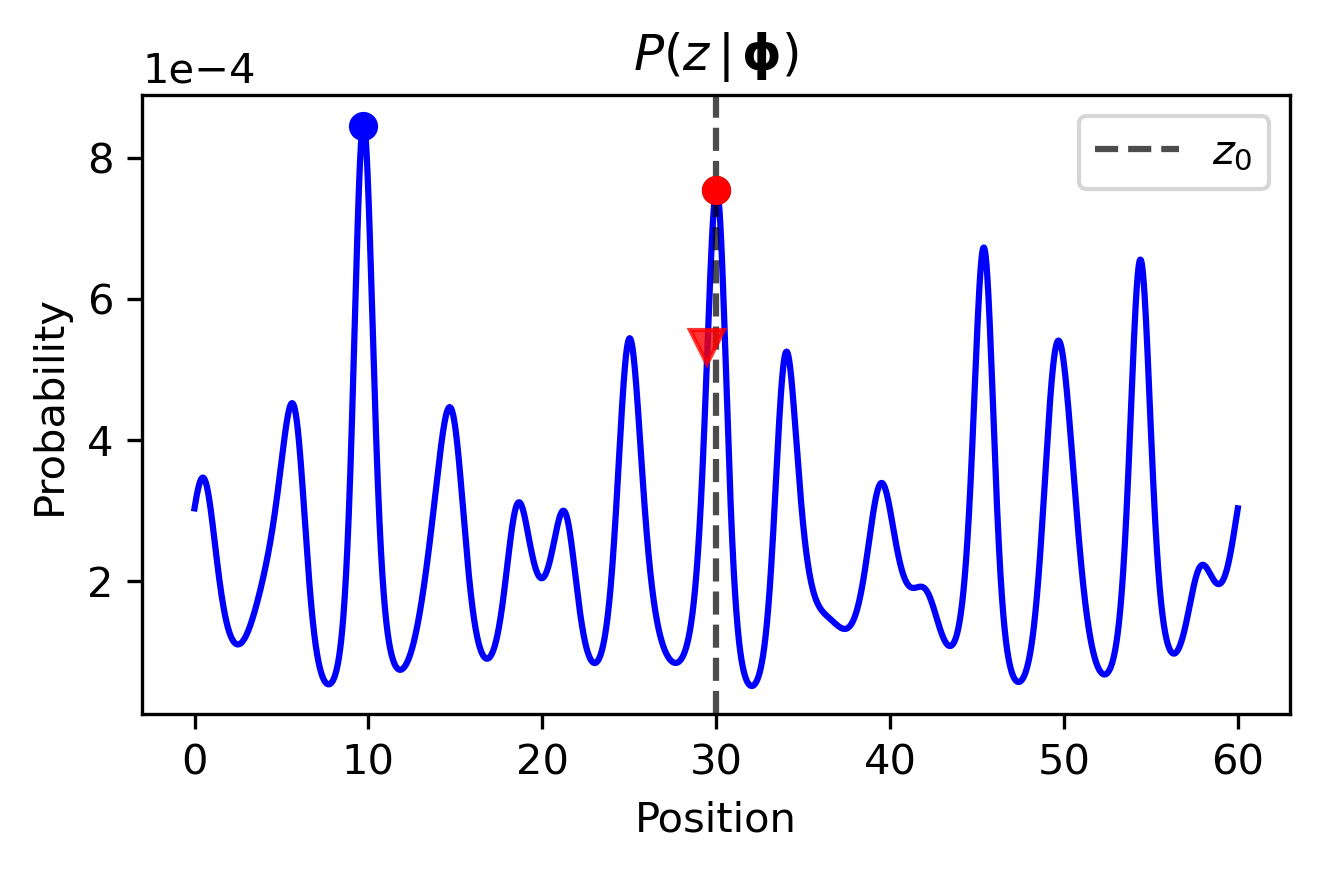

In [ ]:
from matplotlib.ticker import ScalarFormatter

# Decoding probability of psi
logp_psi = prior_function(psi, z_candidates, sigma_phi_infer)
p_psi = np.exp(logp_psi - np.max(logp_psi))
p_psi = p_psi / np.sum(p_psi)

fig, ax = plt.subplots(1, 1, figsize=(4.5, 3), dpi=300)

ax.plot(z_candidates, p_psi, color='blue')
ax.set_xlabel('Position')
ax.set_ylabel('Probability')
ax.grid(False)
# ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))


# Mark z_true=30
ax.axvline(30, color='black', linestyle='--', alpha=0.7, label = '$z_{0}$')
ax.plot(30, np.interp(30, z_candidates, p_psi), 'ko', alpha=0.7)
# Only mark the points for NET and MAP
ax.plot(float(z_decode_n), np.interp(float(z_decode_n), z_candidates, p_psi), 'ro')
ax.plot(float(z_decode_m), np.interp(float(z_decode_m), z_candidates, p_psi), 'bo')
# Mark the point corresponding to x=29
# Use a triangle marker for the point corresponding to x=29.5
ax.plot(29.5, np.interp(29.5, z_candidates, p_psi), marker='v', color='red', markersize=8, alpha=0.8)

# Bold phi
ax.set_title(r"$P(z\,|\,\mathbf{\phi})$")

# Remove all labels
ax.legend()

plt.tight_layout()
plt.show()
